# Assignment 4: Customer Segmentation with Clustering

**Student Name:** Trace Thomason

**Date:** 2-20-26

---

## Assignment Overview

You've been hired as a data science consultant by a UK-based online gift retailer. They're spending the same amount on marketing to all customers regardless of value. Your task: segment their customer base using transaction data from 2009-2011, identify distinct customer groups, and provide actionable recommendations for each segment.

---

## Step 1: Import Libraries and Load Data

In [1]:
pip install pandas matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [8]:
# Load the Online Retail II dataset
df = pd.read_csv('data/online_retail_II.csv', encoding='ISO-8859-1')

# Display basic information
print(df.head())
print(df.info())


print("\n" + "="*80)
print("CHECKPOINT: Verify dataset loaded correctly")
print(f"Dataset shape: {df.shape if df is not None else 'Not loaded'}")
print(f"Date range: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")
print("="*80)


  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice 

---
## Step 2: Aggregate Transaction Data to Customer-Level RFM Features

### Clean Transaction Data

Before aggregating to customer-level, clean the transaction data:
- Remove rows with missing Customer ID
- Remove returns (negative Quantity)
- Create TotalSpend column (Quantity × Price)
- Convert InvoiceDate to datetime

In [9]:
# Clean the data
# Remove missing Customer IDs
df = df.dropna(subset=['Customer ID'])

# Remove negative quantities (returns)
df = df[df['Quantity'] > 0]

# Create TotalSpend column
df['TotalSpend'] = df['Quantity'] * df['Price']

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


print("\n" + "="*80)
print("CHECKPOINT: After data cleaning")
print(f"Remaining transactions: {len(df) if df is not None else 'N/A'}")
print(f"Unique customers: {df['Customer ID'].nunique() if df is not None else 'N/A'}")
print("="*80)



CHECKPOINT: After data cleaning
Remaining transactions: 805620
Unique customers: 5881


### Calculate RFM Features for Each Customer

Create three features for each customer:
- **Recency**: Days since last purchase (use December 10, 2011 as reference date)
- **Frequency**: Total number of unique invoices
- **Monetary**: Total amount spent

In [10]:
# Set reference date for recency calculation
reference_date = pd.to_datetime('2011-12-10')

# For each Customer ID, calculate:
# - Recency: (reference_date - max(InvoiceDate)).days
# - Frequency: count of unique Invoice numbers
# - Monetary: sum of TotalSpend

rfm_df = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalSpend': 'sum'
})

rfm_df.columns = ['Recency', 'Frequency', 'Monetary']

print("\n" + "="*80)
print("CHECKPOINT: RFM Features Created")
if rfm_df is not None:
    print(f"Number of customers: {len(rfm_df)}")
    print(f"\nRFM Summary Statistics:")
    print(rfm_df.describe())
print("="*80)



CHECKPOINT: RFM Features Created
Number of customers: 5881

RFM Summary Statistics:
           Recency    Frequency       Monetary
count  5881.000000  5881.000000    5881.000000
mean    200.992858     6.287196    3017.076888
std     209.489651    13.012879   14734.128619
min       0.000000     1.000000       0.000000
25%      25.000000     1.000000     347.800000
50%      95.000000     3.000000     897.620000
75%     379.000000     7.000000    2304.180000
max     738.000000   398.000000  608821.650000


---
## Step 3: Standardize Features and Determine Optimal k

### Standardize RFM Features

K-means is sensitive to feature scale, so standardize features to mean=0, std=1

In [11]:
# Use StandardScaler to standardize Recency, Frequency, and Monetary
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])

print("\n" + "="*80)
print("CHECKPOINT: Features Standardized")
if rfm_scaled is not None:
    print(f"Scaled features shape: {rfm_scaled.shape}")
    print(f"Mean of scaled features: {rfm_scaled.mean(axis=0)}")
    print(f"Std of scaled features: {rfm_scaled.std(axis=0)}")
print("="*80)



CHECKPOINT: Features Standardized
Scaled features shape: (5881, 3)
Mean of scaled features: [ 9.18232408e-17 -2.77886123e-17  2.41640107e-18]
Std of scaled features: [1. 1. 1.]


### Elbow Method: Test k from 2 to 10

Calculate inertia (within-cluster sum of squares) for different values of k

In [12]:
# Test k values from 2 to 10
# For each k:
#   - Train KMeans(n_clusters=k, random_state=42)
#   - Store inertia value

from sklearn.cluster import KMeans

inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertias.append(kmeans.inertia_)


print("\n" + "="*80)
print("CHECKPOINT: Elbow Method Calculated")
print(f"Tested k values: {list(k_range)}")
print("="*80)



CHECKPOINT: Elbow Method Calculated
Tested k values: [2, 3, 4, 5, 6, 7, 8, 9, 10]


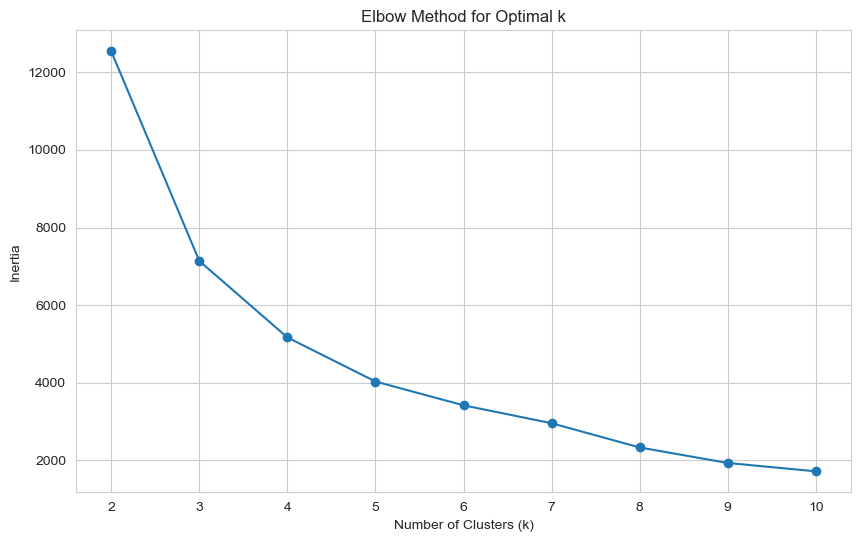

In [13]:
# Plot the elbow curve
# x-axis: k values
# y-axis: inertia

import matplotlib.pyplot as plt

plt.figure()
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()




### Silhouette Score Analysis

Calculate silhouette scores to validate cluster quality

In [14]:
# Calculate silhouette scores for k from 2 to 10
# For each k:
#   - Train KMeans
#   - Calculate silhouette_score(rfm_scaled, labels)

from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    silhouette_scores.append(score)


print("\n" + "="*80)
print("CHECKPOINT: Silhouette Scores Calculated")
print("="*80)



CHECKPOINT: Silhouette Scores Calculated


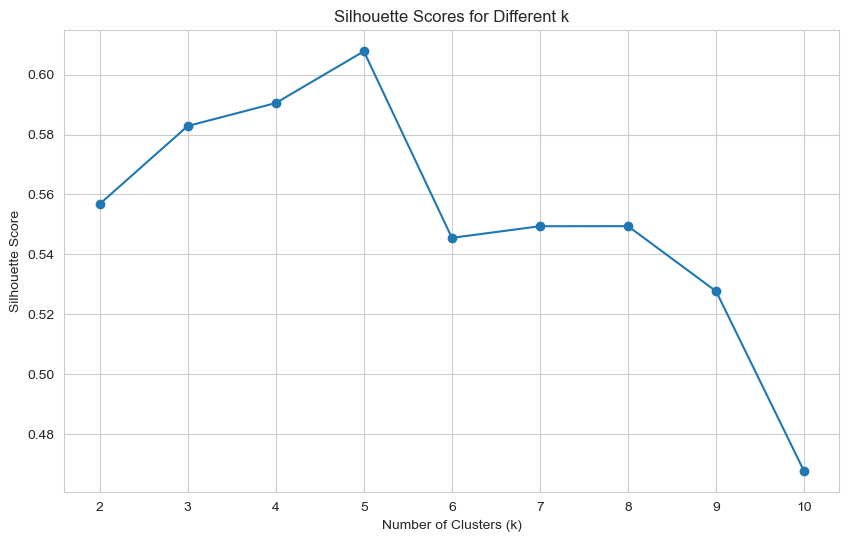

In [15]:
# Plot silhouette scores
# x-axis: k values
# y-axis: silhouette score

plt.figure()
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different k')
plt.show()




### Select Optimal k

**Your k selection justification (write 2-3 sentences):**

Based on the elbow plot, inertia decreases sharply from k = 2 to k = 4 and begins to level off around k = 5, indicating diminishing returns beyond this point. The silhouette score reaches its highest value at k = 5 (approximately 0.61), suggesting strong cluster separation and cohesion. 

Therefore, k = 5 was selected as the optimal number of clusters because it balances compact clusters (low inertia) with the strongest silhouette performance.


In [16]:
# Set your chosen k value
optimal_k = 5  # Selected based on elbow and highest silhouette score

print(f"Chosen k value: {optimal_k}")

Chosen k value: 5


---
## Step 4: Train K-Means Model and Visualize Segments

### Train Final K-Means Model

In [17]:
# Train KMeans with your optimal_k and random_state=42
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(rfm_scaled)

# Add cluster labels to rfm_df
rfm_df['Cluster'] = kmeans.labels_


print("\n" + "="*80)
print("CHECKPOINT: K-Means Model Trained")
print(f"Number of clusters: {optimal_k}")
if 'Cluster' in rfm_df.columns:
    print(f"\nCluster sizes:")
    print(rfm_df['Cluster'].value_counts().sort_index())
print("="*80)



CHECKPOINT: K-Means Model Trained
Number of clusters: 5

Cluster sizes:
Cluster
0    3619
1    1929
2      17
3       2
4     314
Name: count, dtype: int64


### Visualize Customer Segments

Create a 2D scatter plot showing Frequency vs Monetary, colored by cluster

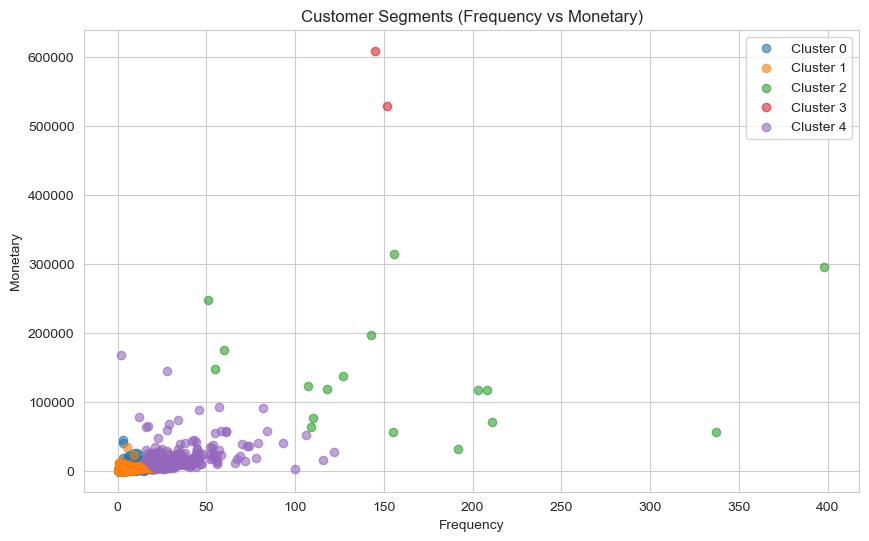

In [19]:
# Create scatter plot
# x-axis: Frequency
# y-axis: Monetary
# color: Cluster
# Include legend

plt.figure(figsize=(10,6))

for cluster in sorted(rfm_df['Cluster'].unique()):
    cluster_data = rfm_df[rfm_df['Cluster'] == cluster]
    plt.scatter(
        cluster_data['Frequency'],
        cluster_data['Monetary'],
        label=f'Cluster {cluster}',
        alpha=0.6
    )

plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('Customer Segments (Frequency vs Monetary)')
plt.legend()
plt.show()




### Calculate Cluster Centers

Show the mean RFM values for each cluster

In [20]:
# Calculate mean Recency, Frequency, and Monetary for each cluster
cluster_summary = rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

print("\n" + "="*80)
print("CLUSTER CENTERS (Mean RFM Values)")
print("="*80)

# Display cluster_summary
print(cluster_summary)

print("="*80)



CLUSTER CENTERS (Mean RFM Values)
            Recency   Frequency       Monetary
Cluster                                       
0         73.795800    5.406190    2036.538555
1        469.925350    2.159150     752.396388
2         27.235294  161.176471  137806.995294
3          0.500000  148.500000  568712.085000
4         25.547771   32.509554   17330.192430


---
## Step 5: Interpret Segments and Provide Business Recommendations

### Segment 0: Moderate Value Regulars

**Customer Profile (3-5 sentences):**

Segment 0 customers have moderate recency (~74 days since last purchase), moderate purchase frequency (~5 transactions), and moderate total spending (~$2,037). They are active but not highly engaged compared to the top-performing clusters. Unlike Clusters 2 and 3, this group purchases occasionally and contributes steady but not exceptional revenue. Compared to Cluster 1 , they are significantly more engaged and valuable.


In [23]:
# Calculate detailed statistics for Segment 0
# Show mean, median, min, max for R, F, M

segment_0 = rfm_df[rfm_df['Cluster'] == 0]
segment_0_stats = segment_0[['Recency', 'Frequency', 'Monetary']].agg(['mean', 'median', 'min', 'max'])
print("\nSegment 0 Statistics")
print(segment_0_stats)




Segment 0 Statistics
         Recency  Frequency      Monetary
mean     73.7958    5.40619   2036.538555
median   46.0000    4.00000   1180.230000
min       0.0000    1.00000      0.000000
max     283.0000   21.00000  44534.300000


### Segment 1: Dormant Low-Value Customers

**Customer Profile (3-5 sentences):**

Segment 1 customers have extremely high recency (~470 days), very low frequency (~2 purchases), and low monetary value (~$752). These customers have not purchased in a long time and historically did not spend much. They appear to be one-time or very infrequent buyers who disengaged quickly. Compared to all other segments, this group shows the weakest relationship with the company.

In [22]:
# Calculate detailed statistics for Segment 1
segment_1 = rfm_df[rfm_df['Cluster'] == 1]
segment_1_stats = segment_1[['Recency', 'Frequency', 'Monetary']].agg(['mean', 'median', 'min', 'max'])
print("\nSegment 1 Statistics")
print(segment_1_stats)


Segment 1 Statistics
          Recency  Frequency      Monetary
mean    469.92535    2.15915    752.396388
median  434.00000    1.00000    376.920000
min     266.00000    1.00000      0.000000
max     738.00000   29.00000  34095.260000


### Segment 2: High-Value Loyal Customers

**Customer Profile (3-5 sentences):**

Segment 2 customers show very low recency (~27 days), extremely high frequency (~161 purchases), and very high spending (~$137,807). These are highly engaged, repeat customers who contribute significant revenue. They purchase often and recently, indicating strong loyalty and ongoing engagement.

In [24]:
# Calculate detailed statistics for Segment 2
segment_2 = rfm_df[rfm_df['Cluster'] == 2]
segment_2_stats = segment_2[['Recency', 'Frequency', 'Monetary']].agg(['mean', 'median', 'min', 'max'])
print("\nSegment 2 Statistics")
print(segment_2_stats)


Segment 2 Statistics
           Recency   Frequency       Monetary
mean     27.235294  161.176471  137806.995294
median    2.000000  143.000000  118628.080000
min       0.000000   51.000000   30861.060000
max     372.000000  398.000000  313946.370000


### Segment 3: Elite / Enterprise Buyers

**Customer Profile (3-5 sentences):**

Segment 3 customers have almost zero recency (~0.5 days), extremely high frequency (~148 purchases), and exceptionally high monetary value (~$568,712). This is a very small, ultra-high-spending group. They likely represent wholesale buyers, corporate accounts, or bulk purchasers.

In [25]:
# Calculate detailed statistics for Segment 3

segment_3 = rfm_df[rfm_df['Cluster'] == 3]
segment_3_stats = segment_3[['Recency', 'Frequency', 'Monetary']].agg(['mean', 'median', 'min', 'max'])
print("\nSegment 3 Statistics")
print(segment_3_stats)



Segment 3 Statistics
        Recency  Frequency    Monetary
mean        0.5      148.5  568712.085
median      0.5      148.5  568712.085
min         0.0      145.0  528602.520
max         1.0      152.0  608821.650


### Segment 4: Emerging High-Potential Customers

**Customer Profile (3-5 sentences):**

Segment 4 customers have low recency (~26 days), moderate frequency (~33 purchases), and strong spending (~$17,330). They are active and engaged but not yet at elite levels like Segments 2 and 3. Their behavior suggests growing loyalty and increasing purchase patterns.

In [26]:
# Calculate detailed statistics for Segment 4

segment_4 = rfm_df[rfm_df['Cluster'] == 4]
segment_4_stats = segment_4[['Recency', 'Frequency', 'Monetary']].agg(['mean', 'median', 'min', 'max'])
print("\nSegment 4 Statistics")
print(segment_4_stats)


Segment 4 Statistics
           Recency   Frequency      Monetary
mean     25.547771   32.509554   17330.19243
median    8.500000   28.000000   12136.33000
min       0.000000    2.000000    1820.44000
max     497.000000  122.000000  168472.50000


---
## Business Recommendations

### Recommendation 1: VIP Retention & Relationship Expansion Program

**Which segment(s) does this target?** High-Value Loyal Customers (Segment 2) and Elite / Enterprise Buyers (Segment 3)

**Recommendation (3-5 sentences):**

The company should implement a tiered VIP retention program for its highest-value customers. This should include early product access, exclusive product bundles, priority shipping, and personalized recommendations based on purchase history. For Segment 3, consider assigning dedicated account management or direct outreach to strengthen relationships. These customers generate a disproportionate share of total revenue, so increasing retention by even a small percentage would significantly boost profitability. Protecting and deepening engagement with this group should be the top strategic priority.

### Recommendation 2: Growth Acceleration Campaign

**Which segment(s) does this target?** Emerging High-Potential Customers (Segment 4)

**Recommendation (3-5 sentences):**

Segment 4 customers demonstrate strong engagement and above-average spending but have not yet reached elite levels. The company should implement targeted cross-selling and upselling campaigns using personalized email marketing and product recommendations. Offering loyalty incentives such as reward points, bundle discounts, or milestone-based perks can encourage increased purchase frequency. These customers already show buying intent, so strategic nudges can convert them into long-term high-value loyalists. Investing in this segment offers strong return potential.


### Recommendation 3: Cost-Optimized Re-Engagement Strategy

**Which segment(s) does this target?** Dormant Low-Value Customers (Segment 1) and Moderate-Value Regulars (Segment 0)

**Recommendation (3-5 sentences):**

Marketing spend on low-engagement customers should be optimized to reduce waste. Instead of costly win-back campaigns, Segment 1 should receive low-cost automated re-engagement emails with limited-time offers or seasonal promotions. For Segment 0, personalized reminders and targeted discounts can encourage increased purchase frequency without heavy spending. This tiered approach prevents overspending on unlikely returners while still nurturing customers with moderate potential. Redirecting savings toward high-value segments will improve overall marketing ROI.

---
## Step 6: Submit Your Work

Before submitting:
1. Make sure all code cells run without errors
2. Verify you have:
   - RFM features properly calculated
   - Elbow method and silhouette score visualizations
   - Written justification for your k selection
   - Customer segment scatter plot
   - Descriptive names and profiles for each segment
   - Three specific business recommendations
3. Check that all visualizations display correctly

Then push to GitHub:
```bash
git add .
git commit -m 'completed customer segmentation assignment'
git push
```

Submit your GitHub repository link on the course platform.